# Guided Project: Classifying Disaster-Related Tweets as Real or Fake

### ***Lu Yang***
### ***07-13-2023***

Solution notebook can be referenced [here]( https://github.com/dataquestio/solutions/blob/master/Mission797Solutions.ipynb).

## Loading the Data

In this project, we’ll be working as a data scientist for a news analytics company interested in monitoring and analyzing news on social media platforms to look for misinformation. One of the most popular platforms is [***Twitter***](https://twitter.com), which has become an important communication channel in times of emergency.

In this context, our company has given us a project in which they want us to build a deep learning text classification model that predicts which Tweets are about real disasters and which aren’t. The dataset comes from [Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/overview).

### Data Description
You'll be using the `train.csv` and `test.csv` datasets that contain five columns:

- `id`: a unique identifier for each tweet
- `keyword`: a particular keyword from the tweet (may be blank)
- `location`: the location the tweet was sent from (may be blank)
- `text`: the text of the tweet
- `target`: denotes whether a tweet is about a real disaster (`1`) or not (`0`). This is the target variable.

### Download the Data
* Download the `train.csv` file [here](https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/train.csv).
* Download the `test.csv` file [here](https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/test.csv).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 100)

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, TextVectorization, Dropout, GlobalAveragePooling1D, Bidirectional
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset

tf.keras.utils.set_random_seed(123)

In [4]:
## download training dataset

!wget https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/train.csv

--2023-07-14 23:04:06--  https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/train.csv
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.235.233, 3.5.25.182, 52.217.117.177, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.235.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987712 (965K) [text/csv]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>] 964.56K   889KB/s    in 1.1s    

2023-07-14 23:04:08 (889 KB/s) - ‘train.csv.1’ saved [987712/987712]



In [5]:
train = pd.read_csv('train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part ...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffer...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,1


In [7]:
train.shape

(7613, 5)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
## count missing values

train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

We can see that the column `id`, `text` and `target` do not contain any missing values. A few entries in the `keyword` column are missing, whereas a significant portion of the `location` column is missing.

In [10]:
## number of unique values

train.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

## Data Exploration

We will only be using the `text` column as the predictor, considering:
* The `id` column is irrelevant for our task.
* The `keyword` column is redundant as the keyword appears in the text anyways.
* The `location` column has too many missing values and thus improper to remove or impute missing values.

In [11]:
train = train.drop(['id', 'keyword', 'location'], axis = 1)
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [12]:
train['target'].value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

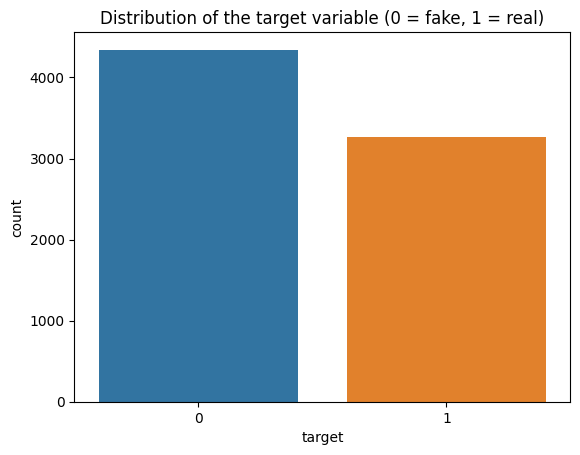

In [13]:
sns.countplot(data = train, x = 'target').set(
    title = 'Distribution of the target variable (0 = fake, 1 = real)'
)
plt.show()

On average, there is a slightly higher likelihood for the disaster tweet to be fake (`57 %`) instead of real (`43 %`). The two classes are still quite comparable without being heavily skewed toward one versus the other.

## Text Preprocessing
### 1. Convert to lower case

In [14]:
train['text'] = train['text'].str.lower()
train.head()

,text,target
0,our deeds are the reason of this #earthquake may allah forgive us all,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are being notified by officers. no other evacuation or...,1
3,"13,000 people receive #wildfires evacuation orders in california",1
4,just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school,1


### 2. Remove punctuations and numbers

In [15]:
import re

def remove_punctuation_and_number(text: str):

    return re.sub(r'[^a-zA-Z]', ' ', text)

In [16]:
train['text'] = train['text'].apply(remove_punctuation_and_number)
train.head()

,text,target
0,our deeds are the reason of this earthquake may allah forgive us all,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are being notified by officers no other evacuation or...,1
3,people receive wildfires evacuation orders in california,1
4,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,1


### 3. Tokenize

In [17]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
train['text'] = train['text'].apply(word_tokenize)
train.head()

,text,target
0,"[our, deeds, are, the, reason, of, this, earthquake, may, allah, forgive, us, all]",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[all, residents, asked, to, shelter, in, place, are, being, notified, by, officers, no, other, e...",1
3,"[people, receive, wildfires, evacuation, orders, in, california]",1
4,"[just, got, sent, this, photo, from, ruby, alaska, as, smoke, from, wildfires, pours, into, a, s...",1


### 4. Remove stopwords

Since we are trying to classify real messages against fake, the word "***not***" will contain meaningful information and should not be treated just as stopwords.

In [19]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def remove_stopwords(tokens: list, stop_words):

    return [token for token in tokens if token not in stop_words]

In [21]:
train['text'] = train['text'].apply(remove_stopwords, stop_words = stop_words)
train.head()

,text,target
0,"[deeds, reason, earthquake, may, allah, forgive, us]",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[residents, asked, shelter, place, notified, officers, evacuation, shelter, place, orders, expec...",1
3,"[people, receive, wildfires, evacuation, orders, california]",1
4,"[got, sent, photo, ruby, alaska, smoke, wildfires, pours, school]",1


### 5. Lemmatize

In [22]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
lemmatizer = WordNetLemmatizer()

def lemmatize_word(tokens: list, lemmatizer: WordNetLemmatizer):

    return [lemmatizer.lemmatize(token, pos = 'v') for token in tokens]

In [24]:
train['text'] = train['text'].apply(lemmatize_word, lemmatizer = lemmatizer)
train.head()

,text,target
0,"[deeds, reason, earthquake, may, allah, forgive, us]",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[residents, ask, shelter, place, notify, officer, evacuation, shelter, place, order, expect]",1
3,"[people, receive, wildfires, evacuation, order, california]",1
4,"[get, send, photo, ruby, alaska, smoke, wildfires, pour, school]",1


### 6. Join the tokens into processed text

In [25]:
train['text_final'] = train['text'].str.join(' ')
train['text_final'].head()

0                                        deeds reason earthquake may allah forgive us
1                                               forest fire near la ronge sask canada
2    residents ask shelter place notify officer evacuation shelter place order expect
3                                people receive wildfires evacuation order california
4                              get send photo ruby alaska smoke wildfires pour school
Name: text_final, dtype: object

## Visualization with WordCloud

In [26]:
train_real = train[train.target == 1]
train_fake = train[train.target == 0]

In [27]:
train_real['text_final'].str.split(' ', expand = True).stack().value_counts()[:20]

co            2529
http          2382
fire           273
bomb           187
kill           162
news           151
amp            135
https          135
flood          122
via            121
get            121
disaster       121
crash          115
california     115
suicide        112
train          109
police         109
people         106
attack         106
home           105
dtype: int64

In [28]:
train_real.loc[train_real['text_final'].str.split(' ').apply(lambda x: 'co' in x), 'text_final'].sample(10, random_state = 2)

3357    rocky fire northern california swell acres evacuate http co mtfnbhryzq portland phoenix miami at...
5565    tomorrow even commute receive red light rainstorm impact region push way late even http co drvm ...
7115                      pov video capture violent land amsterdam airport schiphol storm http co fkv qxdcy
6390                  yr old pkk suicide bomber detonate bomb turkey army trench release http co mmklapx ok
6811                                                            csaresu american tragedy http co sdmrzgeryx
5890                                           watch airport get swallow sandstorm minute http co tr kvxctw
5265     kinder morgan twon tell cityofkamloops respond oil spill trust see sec kamloops http co ta n szyfp
2009          homeowners insurance cover water damage good things know http co usdi jcho http co xyg jhrjof
1813    http co igxrqpotm bin lade family plane crash avoid microlight landi http co kpbu hgt peritoengr...
6183              photoset h

In [29]:
train_fake['text_final'].str.split(' ', expand = True).stack().value_counts()[:20]

co       2212
http     1927
get       322
like      294
https     277
not       211
amp       209
go        200
new       171
make      133
one       133
body      119
love      118
see       115
u         115
bag       112
time      109
come      109
say       107
think     105
dtype: int64

In [30]:
text_real_concat = ' '.join(list(train_real['text_final']))
text_real_concat[:1000]

'deeds reason earthquake may allah forgive us forest fire near la ronge sask canada residents ask shelter place notify officer evacuation shelter place order expect people receive wildfires evacuation order california get send photo ruby alaska smoke wildfires pour school rockyfire update california hwy close directions due lake county fire cafire wildfires flood disaster heavy rain cause flash flood streets manitou colorado spring areas top hill see fire woods emergency evacuation happen build across street afraid tornado come area three people die heat wave far haha south tampa get flood hah wait second live south tampa gon na gon na fvck flood rain flood florida tampabay tampa days lose count flood bago myanmar arrive bago damage school bus multi car crash break bbcmtd wholesale market ablaze http co lhyxeohy c africanbaze break news nigeria flag set ablaze aba http co nndbgwyei inec office abia set ablaze http co imaomknna barbados bridgetown jamaica two cars set ablaze santa cruz 

In [31]:
text_fake_concat = ' '.join(list(train_fake['text_final']))
text_fake_concat[:1000]

'man love fruit summer lovely car fast goooooooaaaaaal ridiculous london cool love ski wonderful day looooool way eat shit nyc last week love girlfriend cooool like pasta end always try bring heavy metal rt http co yao e xngw cry set ablaze plus side look sky last night ablaze http co qqsmshaj n phdsquares mufc build much hype around new acquisitions doubt set epl ablaze season ablaze lord check http co roi nsmejj http co tj zjin http co yduixefipe http co lxtjc kls nsfw outside ablaze alive dead inside awesome time visit cfc head office ancop site ablaze thank tita vida take care us soooo pump ablaze southridgelife want set chicago ablaze preach not hotel http co qknbfofx gain followers last week know stats grow http co tiyulif c build perfect tracklist life leave streets ablaze check http co roi nsmejj http co tj zjin http co yduixefipe http co lxtjc kls nsfw first night retainers quite weird better get use wear every single night next year least santa cruz head st elizabeth police s

Text(0.5, 1.0, 'Frequently used words (monogram and bigram) in disaster related Tweets')

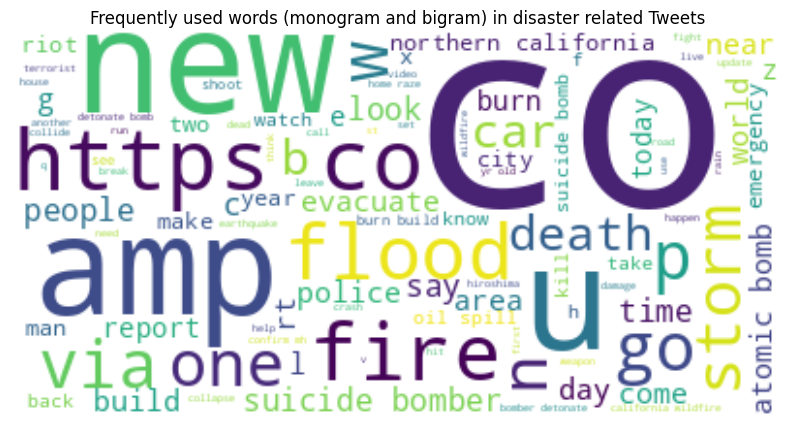

In [32]:
from wordcloud import WordCloud

words_real = WordCloud(max_words = 100, random_state = 1, background_color = 'white', collocations = True).generate(text_real_concat)

plt.figure(figsize = (10,6))
plt.imshow(words_real, interpolation = 'bilinear')
plt.axis('off')
plt.title('Frequently used words (monogram and bigram) in disaster related Tweets')

Text(0.5, 1.0, 'Frequently used words (monogram and bigram) in non-disaster related Tweets')

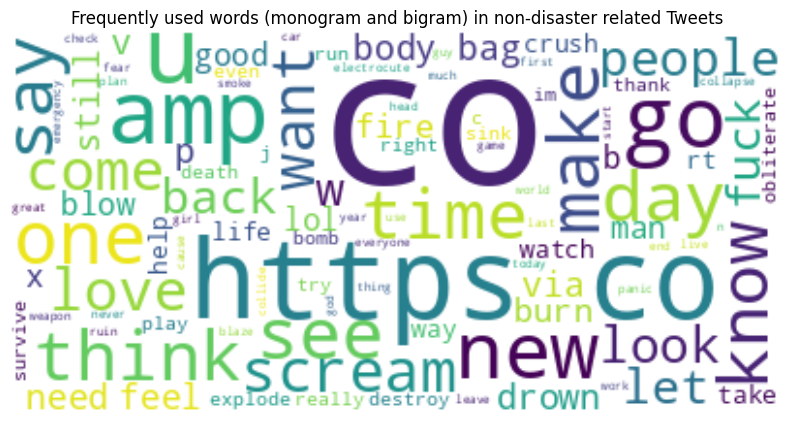

In [33]:
words_fake = WordCloud(max_words = 100, random_state = 1, background_color = 'white', collocations = True).generate(text_fake_concat)

plt.figure(figsize = (10,6))
plt.imshow(words_fake, interpolation = 'bilinear')
plt.axis('off')
plt.title('Frequently used words (monogram and bigram) in non-disaster related Tweets')

There are indeed some differences in the list of frequent words for disaster relevant tweets compared to those irrelevant. The disaster related tweets contain words like ***“fire”, "bomb”, “kill”***, etc. that appear to be correlated with the consequences of a disaster. Interestingly, regardless of the relevancy to disaster, the ***“http”*** and ***“co”*** are commonly seen in tweets, potentially due to some inline URL links.

## Build a Shallow Neural Network

In [34]:
## Use a 80-20 train-test split

X = train['text_final']
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [35]:
X_train.shape, X_test.shape

((6090,), (1523,))

In [36]:
## Create TextVectorization & Embedding layer

max_tokens = 5000
sequence_length = 128
embedding_length = 128

vectorizer_layer = TextVectorization(max_tokens = max_tokens, standardize ='lower_and_strip_punctuation', ngrams = (1,2), output_mode = 'int',
    output_sequence_length = sequence_length)
vectorizer_layer.adapt(X_train)

embedding_layer = Embedding(input_dim = max_tokens, output_dim = embedding_length, input_length = sequence_length)

In [37]:
def create_nn_model(vectorizer_layer, embedding_layer):

    inputs = Input(shape = (1,), dtype = tf.string)

    x = vectorizer_layer(inputs)
    x = embedding_layer(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dense(16, activation = 'relu')(x)
    outputs = Dense(1, activation = 'sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [38]:
model_shallow_nn = create_nn_model(vectorizer_layer, embedding_layer)
model_shallow_nn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 128)          640000    
                                                                 
 dense (Dense)               (None, 128, 64)           8256      
                                                                 
 dense_1 (Dense)             (None, 128, 16)           1040      
                                                                 
 dense_2 (Dense)             (None, 128, 1)            17        
                                                             

In [39]:
def evaluate_model(model, X_train, y_train, X_test, y_test, epochs = 10):

    model.fit(X_train, y_train, epochs = epochs)
    print()
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print()
    print(f'Test loss: {test_loss}\nTest accuracy: {test_acc}')

In [40]:
evaluate_model(model_shallow_nn, X_train, y_train, X_test, y_test)

Epoch 1/10
191/191 [==============================] - 39s 164ms/step - loss: 0.6776 - accuracy: 0.5816
Epoch 2/10
191/191 [==============================] - 9s 48ms/step - loss: 0.6703 - accuracy: 0.5869
Epoch 3/10
191/191 [==============================] - 4s 19ms/step - loss: 0.6691 - accuracy: 0.5876
Epoch 4/10
191/191 [==============================] - 2s 12ms/step - loss: 0.6687 - accuracy: 0.5879
Epoch 5/10
191/191 [==============================] - 2s 12ms/step - loss: 0.6699 - accuracy: 0.5859
Epoch 6/10
191/191 [==============================] - 4s 20ms/step - loss: 0.6684 - accuracy: 0.5880
Epoch 7/10
191/191 [==============================] - 3s 14ms/step - loss: 0.6679 - accuracy: 0.5882
Epoch 8/10
191/191 [==============================] - 2s 8ms/step - loss: 0.6675 - accuracy: 0.5885
Epoch 9/10
191/191 [==============================] - 2s 11ms/step - loss: 0.6676 - accuracy: 0.5885
Epoch 10/10
191/191 [==============================] - 2s 10ms/step - loss: 0.6675 - accur

Our accuracy for a fully-connected neural network model is about 59 % for both training and testing set, which is marginally above the average fake percentage of 57 %. Not impressive thus far!

## Build a Multilayer Deep Text Classification Model

In [41]:
def create_deep_nn_model(vectorizer_layer, embedding_layer):

    inputs = Input(shape = (1,), dtype = tf.string)

    x = vectorizer_layer(inputs)
    x = embedding_layer(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation = 'relu', kernel_regularizer = L2(l2 = 0.001))(x)
    x = Dropout(rate = 0.2)(x)
    x = Dense(32, activation = 'relu', kernel_regularizer = L2(l2 = 0.001))(x)
    x = Dropout(rate = 0.1)(x)
    x = Dense(16, activation = 'relu', kernel_regularizer = L2(l2 = 0.0005))(x)
    x = Dense(4, activation = 'relu', kernel_regularizer = L2(l2 = 0.0005))(x)
    outputs = Dense(1, activation = 'sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [42]:
model_deep_nn = create_deep_nn_model(vectorizer_layer, embedding_layer)
model_deep_nn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 128)          640000    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0   

In [43]:
evaluate_model(model_deep_nn, X_train, y_train, X_test, y_test)

Epoch 1/10
191/191 [==============================] - 21s 90ms/step - loss: 0.4962 - accuracy: 0.7854
Epoch 2/10
191/191 [==============================] - 6s 31ms/step - loss: 0.3771 - accuracy: 0.8570
Epoch 3/10
191/191 [==============================] - 4s 18ms/step - loss: 0.3490 - accuracy: 0.8688
Epoch 4/10
191/191 [==============================] - 3s 15ms/step - loss: 0.3201 - accuracy: 0.8791
Epoch 5/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2764 - accuracy: 0.9007
Epoch 6/10
191/191 [==============================] - 3s 17ms/step - loss: 0.2741 - accuracy: 0.9008
Epoch 7/10
191/191 [==============================] - 3s 15ms/step - loss: 0.2370 - accuracy: 0.9159
Epoch 8/10
191/191 [==============================] - 2s 8ms/step - loss: 0.2326 - accuracy: 0.9195
Epoch 9/10
191/191 [==============================] - 3s 15ms/step - loss: 0.2196 - accuracy: 0.9205
Epoch 10/10
191/191 [==============================] - 2s 9ms/step - loss: 0.2101 - accurac

With the addition of a ` GlobalAveragePooling1D` layer the training accuracy significantly improves to 92 %. The testing accuracy, however, is substantially lower with a value of 79 %. This signifies overfitting while not completely resolved by the `L2` regularization and the `Dropout` layers.

## Building a Multilayer Bidirectional LSTM Model

In [44]:
def create_bi_lstm_model(vectorizer_layer, embedding_layer):

    inputs = Input(shape = (1,), dtype = tf.string)

    x = vectorizer_layer(inputs)
    x = embedding_layer(x)
    x = Bidirectional(LSTM(64, return_sequences = True), merge_mode = 'ave')(x)
    x = Bidirectional(LSTM(64, return_sequences = True), merge_mode = 'ave')(x)
    x = Bidirectional(LSTM(32), merge_mode = 'ave')(x)
    x = Dense(32, activation = 'relu', kernel_regularizer = L2(l2 = 0.001))(x)
    x = Dropout(rate = 0.2)(x)
    x = Dense(16, activation = 'relu', kernel_regularizer = L2(l2 = 0.0005))(x)
    x = Dense(8, activation = 'relu', kernel_regularizer = L2(l2 = 0.0005))(x)
    x = Dense(4, activation = 'relu', kernel_regularizer = L2(l2 = 0.0005))(x)
    outputs = Dense(1, activation = 'sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [45]:
model_bi_lstm = create_bi_lstm_model(vectorizer_layer, embedding_layer)
model_bi_lstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 128)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128, 64)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 64)          66048     
 nal)                                                            
                                                           

In [46]:
evaluate_model(model_bi_lstm, X_train, y_train, X_test, y_test)

Epoch 1/10
191/191 [==============================] - 36s 116ms/step - loss: 0.4617 - accuracy: 0.8274
Epoch 2/10
191/191 [==============================] - 11s 59ms/step - loss: 0.3288 - accuracy: 0.8867
Epoch 3/10
191/191 [==============================] - 9s 45ms/step - loss: 0.2640 - accuracy: 0.9117
Epoch 4/10
191/191 [==============================] - 6s 33ms/step - loss: 0.2324 - accuracy: 0.9238
Epoch 5/10
191/191 [==============================] - 7s 39ms/step - loss: 0.1954 - accuracy: 0.9312
Epoch 6/10
191/191 [==============================] - 6s 33ms/step - loss: 0.1731 - accuracy: 0.9401
Epoch 7/10
191/191 [==============================] - 8s 41ms/step - loss: 0.1676 - accuracy: 0.9417
Epoch 8/10
191/191 [==============================] - 6s 31ms/step - loss: 0.1571 - accuracy: 0.9438
Epoch 9/10
191/191 [==============================] - 7s 39ms/step - loss: 0.1630 - accuracy: 0.9440
Epoch 10/10
191/191 [==============================] - 6s 32ms/step - loss: 0.1392 - acc

The `Bidirectional` `LSTM` based model performs similarly compared to the ` GlobalAveragePooling1D` containing model, showing some indications of overfitting as well.

## Building a Transformer Model

In [47]:
!pip install transformers

In [48]:
import transformers
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [49]:
tokenizer.is_fast, tokenizer.vocab_size, tokenizer.model_max_length

(True, 30522, 512)

In [50]:
train_encodings = tokenizer(list(X_train), max_length = sequence_length, truncation = True, padding = True)
test_encodings = tokenizer(list(X_test), max_length = sequence_length, truncation = True, padding = True)

In [51]:
print(list(X_train)[0])
print(train_encodings[0].tokens)
print(train_encodings[0].ids)
print(train_encodings[0].attention_mask)

sioux city fire officials believe bridge collapse lead cement truck roll siouxland matter siouxlan http co sztgmbkohg
['[CLS]', 'sioux', 'city', 'fire', 'officials', 'believe', 'bridge', 'collapse', 'lead', 'cement', 'truck', 'roll', 'sioux', '##land', 'matter', 'sioux', '##lan', 'http', 'co', 's', '##z', '##t', '##gm', '##b', '##ko', '##hg', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[101, 16615, 2103, 2543, 4584, 2903, 2958, 7859, 2599, 11297, 4744, 4897, 16615, 3122, 3043, 16615, 5802, 8299, 2522, 1055, 2480, 2102, 21693, 2497, 3683, 25619, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [52]:
train_dataset = Dataset.from_tensor_slices(
    (dict(train_encodings), tf.constant(y_train, dtype = tf.int32))
                                           )

test_dataset = Dataset.from_tensor_slices(
    (dict(test_encodings), tf.constant(y_test, dtype = tf.int32))
                                           )

In [53]:
train_dataset = train_dataset.shuffle(len(X_train)).batch(32)
test_dataset = test_dataset.batch(32)

In [54]:
from transformers import TFAutoModelForSequenceClassification

model_transformer = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2)
model_transformer.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_22 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [55]:
optimizer = Adam(learning_rate = 2e-5)
loss = SparseCategoricalCrossentropy(from_logits = True)
metrics = SparseCategoricalAccuracy()

model_transformer.compile(optimizer = optimizer, loss = loss, metrics = [metrics])

In [56]:
model_transformer.fit(train_dataset, epochs = 3, validation_data = test_dataset)

Epoch 1/3
191/191 [==============================] - 94s 245ms/step - loss: 0.4700 - sparse_categorical_accuracy: 0.7885 - val_loss: 0.4152 - val_sparse_categorical_accuracy: 0.8168
Epoch 2/3
191/191 [==============================] - 34s 179ms/step - loss: 0.3633 - sparse_categorical_accuracy: 0.8544 - val_loss: 0.4292 - val_sparse_categorical_accuracy: 0.8162
Epoch 3/3
191/191 [==============================] - 33s 170ms/step - loss: 0.2867 - sparse_categorical_accuracy: 0.8901 - val_loss: 0.4267 - val_sparse_categorical_accuracy: 0.8319


The transformer model performs much better on the testing set with less overfitting behavior than the previous models maybe due to the benefits from the ***attention*** mechanism.